<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


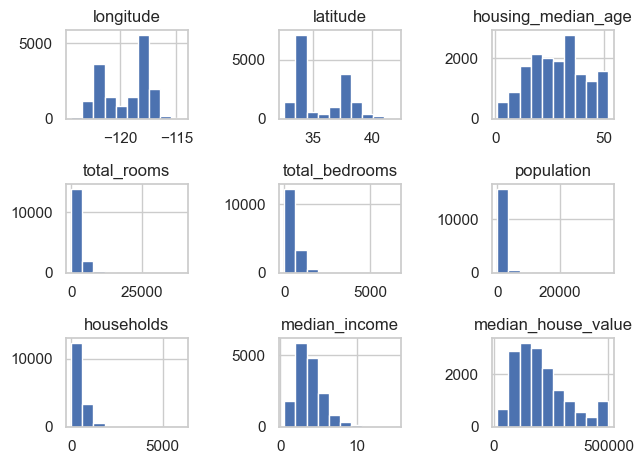

Mean Squared Error: 4528742639.841299
R-squared: 0.6688348980028487


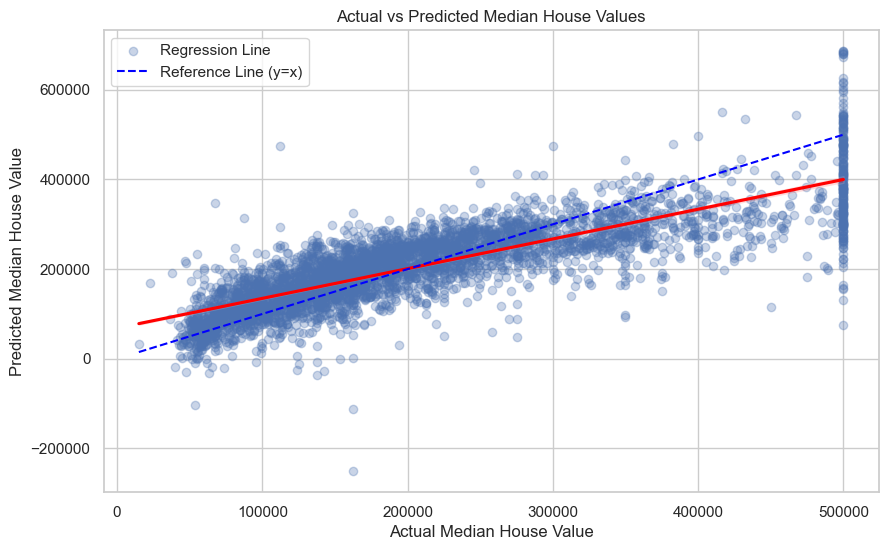

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


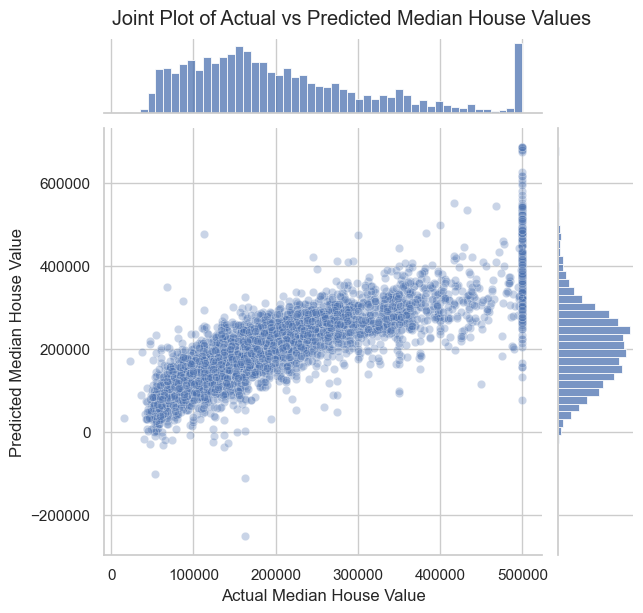

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
data = pd.read_csv("housing.csv")

'''
1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea
'''

# data # to see the data

# to predict the median house value our target variable is median_house_value

# Data info to check for null values
data.info()

# total_bedrooms has 20433 non-null values so it has a 200 of missing ones

# Drop rows with null values 
# inplace=True saves our new values in the data object
data.dropna(inplace=True)

# Separate features (X) and target variable (y)
x = data.drop(['median_house_value'], axis=1)
y = data['median_house_value']

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

'''
FEATURES
    - predictors
    - attributes or properties of the data that are used as inputs to the machine learning algorithm.

TARGET VALUES
    - labels
    - dependent variables that the model aims to predict based on the input features.
    
X represents the features.
y represents the target values.
'''

# Combine x_train and y_train for preprocessing
train_data = x_train.join(y_train)

#train_data
train_data.hist()
plt.tight_layout() #adjusts the subplots to fit in the figure area.
plt.show() #displays the plot

'''
Many real-world datasets have features where most values are small, but a few are very large, 
creating a right-skewed distribution. 
This skewness can cause problems for some models. 
By applying a logarithm transformation, 
we can reduce the impact of these large values and 
make the distribution more balanced and symmetric, 
which can help the model perform better.
'''

# Log transformation to reduce skewness
train_data['total_rooms'] = np.log(train_data["total_rooms"] + 1)
train_data['total_bedrooms'] = np.log(train_data["total_bedrooms"] + 1)
train_data['population'] = np.log(train_data["population"] + 1)
train_data['households'] = np.log(train_data["households"] + 1)

#train_data.hist(figsize = (15,8))

#The data now looks more like a gaussian belt curve (symmetric "bell curve" shape)

# Handle categorical variable 'ocean_proximity'
train_data = train_data.join(pd.get_dummies(train_data.ocean_proximity)).drop(['ocean_proximity'], axis=1)

# Create new feature 'bedroom_ratio'
train_data['bedroom_ratio'] = train_data['total_bedrooms'] / train_data['total_rooms']

# Prepare the final training data
x_train = train_data.drop(['median_house_value'], axis=1)
y_train = train_data['median_house_value']

# Initialize and train the Linear Regression model
reg = LinearRegression()
reg.fit(x_train, y_train)

# Preprocess the test data similarly
x_test['total_rooms'] = np.log(x_test["total_rooms"] + 1)
x_test['total_bedrooms'] = np.log(x_test["total_bedrooms"] + 1)
x_test['population'] = np.log(x_test["population"] + 1)
x_test['households'] = np.log(x_test["households"] + 1)
x_test = x_test.join(pd.get_dummies(x_test.ocean_proximity)).drop(['ocean_proximity'], axis=1)
x_test['bedroom_ratio'] = x_test['total_bedrooms'] / x_test['total_rooms']

# Ensure that the columns in x_test match those in x_train
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

# Make predictions on the test set
y_pred = reg.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# plotting of predictions vs actual values with legends
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Scatter plot with regression line
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.3}, line_kws={"color": "red"}, label='Regression Line')
plt.xlabel('Actual Median House Value')
plt.ylabel('Predicted Median House Value')
plt.title('Actual vs Predicted Median House Values')

# Add a reference line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue', linestyle='--', label='Reference Line (y=x)')

# Add legend
plt.legend()

plt.show()

# Jointplot for a more comprehensive view
sns.jointplot(x=y_test, y=y_pred, kind='scatter', alpha=0.3, marginal_kws=dict(bins=50, fill=True))
plt.xlabel('Actual Median House Value')
plt.ylabel('Predicted Median House Value')
plt.suptitle('Joint Plot of Actual vs Predicted Median House Values', y=1.02)
plt.show()

